# 4D Seismic Carbon Storage Tracking

## Sleipner CCS Project

Since 1996, Equinor, the Norwegian state-owned energy company, has been injecting CO2 into the Earth's subsurface in offshore Norway as part of their Sleipner carbon capture and storage project. Similar to how subsurface geological structures can trap oil and gas for thousands or millions of years, the injected CO2 is stored in a porous layer of sandstone and is prevented from migrating upwards by a sealing layer of shale. Sleipner was the world's first offshore carbon capture and storage plant and has seen approximately 1 million tonnes of CO2 injected each year reducing Norway's "business-as-usual" CO2 emissions by 3%. <br><br>

<img src="map.png" alt="Sleipner_map" width="800"><br>
<a href="www.sccs.org.uk/map">Global CCS Map</a>
<br><br>

## Seismic imaging

Seismic imaging is a technique in which seismic waves are bounced off different layers of material in the subsurface, recorded and processed to create an interpretable image. In the case of the Sleipner site, repeated seismic imaging surveys have been performed to monitor the accumulation and migration of CO2 across time. Equinor and their partners have made these seismic images freely available on the co2datashare.org website and are the subject of this hackathon challenge.<br><br>

## Data Acknowledgement

Many thanks to the Sleipner group for providing the seismic data used in the cells below.<br>
https://co2datashare.org/dataset/sleipner-4d-seismic-dataset<br>
https://co2datashare.org/sleipner-2019-benchmark-model/static/license.pdf
<br><br>

## Data loading and visualisation

First, we will load the data and familiarise ourselves with it by displaying a slice:

## import libraries

In [107]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

## read base (1994), monitor 1 (2001) and monitor 2 (2006) surveys' data

In [108]:
seismic = pd.read_parquet("Sleipner_4D_Seismic_Small.parquet.gzip", engine = "pyarrow")
display(seismic)

,z,x,y,94,01,06
0,0.0,956,1716,0.000026,-0.006091,-0.005390
1,0.0,956,1717,0.002181,-0.015860,0.009069
2,0.0,956,1718,0.000025,-0.009283,-0.006776
3,0.0,956,1719,-0.003922,-0.009160,-0.004944
4,0.0,956,1720,0.000031,-0.010252,-0.008233
...,...,...,...,...,...,...
64241995,1498.0,1299,1960,-0.285229,-0.257875,-0.349266
64241996,1498.0,1299,1961,-0.322909,-0.257242,-0.310981
64241997,1498.0,1299,1962,-0.232337,-0.178725,-0.181341
64241998,1498.0,1299,1963,-0.205845,-0.152657,-0.102178


Above you can see the data stored in a Pandas DataFrame. There are spatial z, x and y columns along with the seismic amplitude at those coordinates in 94 (1994), 01 (2001) and 06 (2006) seismic surveys. (for those with pre-existing seismic imaging experience z is twt, x is xline and y is iline)

## define a function to display slices of seismic data

In [109]:
def show(data, const_axis, const_val, x_axis, y_axis, z_axis, colour = "gray", z_min = -2, z_max = 2):
    data = data.loc[data[const_axis] == const_val]
    data = data.pivot(columns = x_axis, index = y_axis, values = z_axis)
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.imshow(data, cmap = colour, vmin = z_min, vmax = z_max)
    return plt.show(fig)

## display slice y=1800 of 1994 data

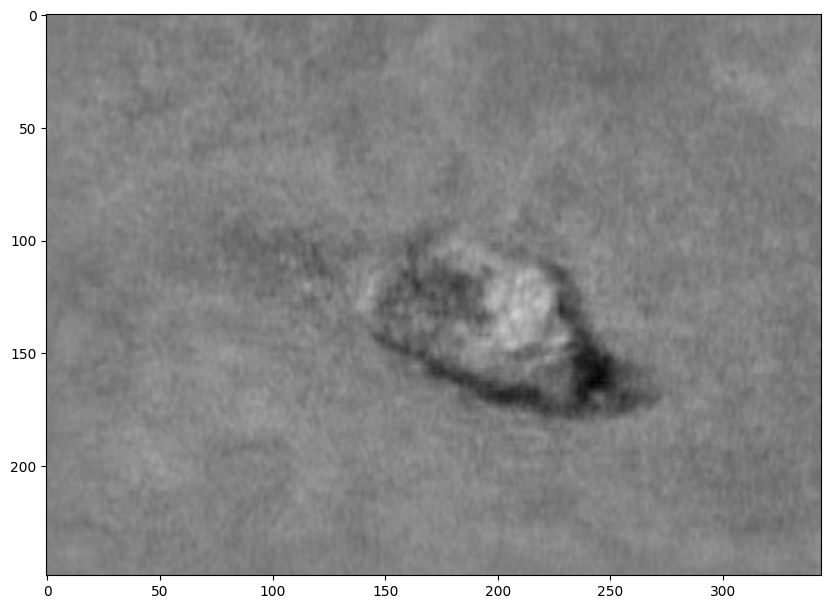

In [110]:
show(seismic, "z", 1000, "x", "y", "06")

Above you can see a vertical slice of the 1994 survey. That bold white line near the top is the water bottom - the boundary between the ocean and the subsurface. All of the seismic amplitude beneath that water bottom is being reflected off the boundaries between different layers of rock, and the boundaries between the different materials that the porous rocks hold (CO2, natural gas, salt water, oil).

## The challenge:

Here's the hackathon challenge. <b>Create a function which automatically spatially selects the newly accumulated or migrated CO2 from one year's survey to another.</b> If you look at the change in seismic amplitude between one survey and the next you should be able to see a strong change in seismic amplitude in some places as a result of CO2 accumulating in the subsurface.<br><br>

Below is an image of the raw seismic amplitude showing a region of injected CO2:
<img src="seismic.png" alt="Raw seismic example" width="200"> 

And by performing k-means clustering with amplitude, x, y and z as vector dimensions we have been able to highlight the CO2:
 <img src="co2_selection.png" alt="CO2 selection example" width="200">
This is not perfect, however, the water bottom is being selected despite it not having accumulated any CO2.
<br><br>
## Over to you.
There are no constraints on how you attempt this challenge other than your function for selecting migrated CO2 should be automatic i.e. don't manually fit a polygon to the CO2. Please ask us as many questions as you like. We can provide ideas on how to start and can help you better understand the seismic data and the geology.

C:\Users\punch\AppData\Local\Temp\ipykernel_9312\3660185751.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sliceSeismic["labels"] = kmeans.labels_


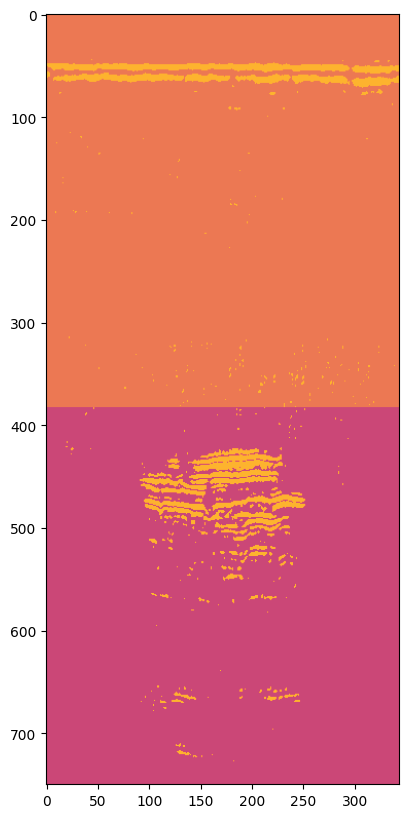

In [111]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
seismic["diff0694"] = abs(seismic["06"] - seismic["94"])

sliceSeismic = seismic.loc[seismic["y"] ==  1840]
scaler = StandardScaler()
scaled_seismic = scaler.fit_transform(sliceSeismic)
no_x = sliceSeismic.filter(["z", "diff0694"], axis=1)
no_x = scaler.fit_transform(no_x)
kmeans = KMeans(
init="random",
n_clusters=3,
n_init=10,
max_iter=500
)

kmeans.fit(no_x)
sliceSeismic["labels"] = kmeans.labels_
data = sliceSeismic.pivot(columns = "x", index = "z", values = "labels")
fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(data, cmap = "plasma", vmin = -3, vmax = 3)
plt.show(fig)


C:\Users\punch\AppData\Local\Temp\ipykernel_9312\3095556215.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sliceSeismic_water["labels"] = kmeans.labels_


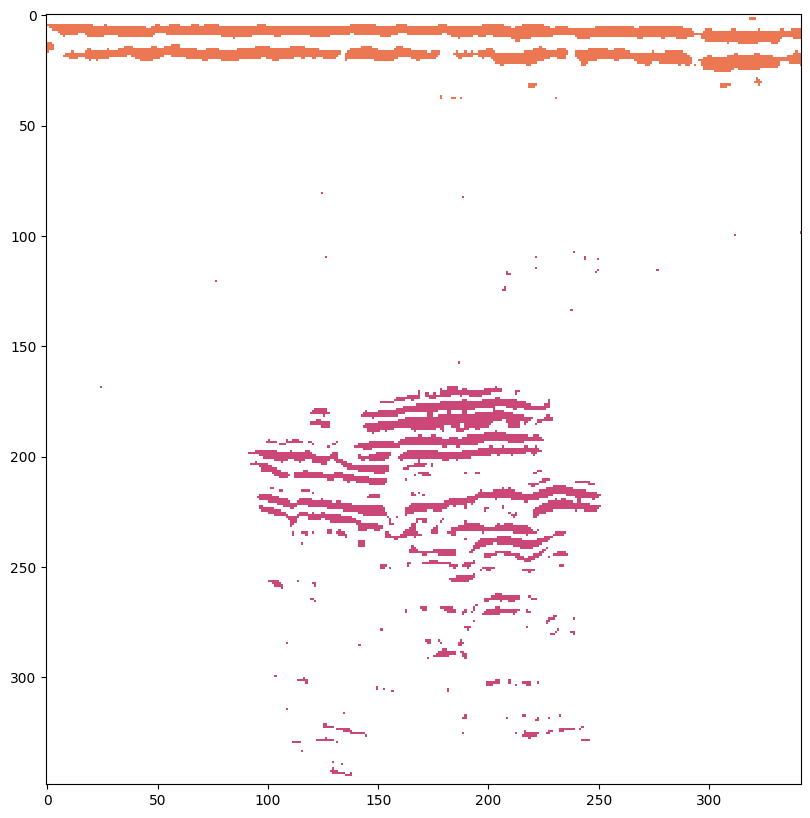

In [112]:
labels_sizes=sliceSeismic.groupby(["labels"]).size()
#print(labels_sizes)
#print(type(labels_sizes))
label_of_carbon_dioxide=labels_sizes.argmin()
#print("krowa")
#print(label_of_carbon_dioxide)
#print(type(label_of_carbon_dioxide))
#print(label_of_carbon_dioxide.shape)
#print(len(label_of_carbon_dioxide))
sliceSeismic_water = sliceSeismic[sliceSeismic["labels"]==label_of_carbon_dioxide]
scaler = StandardScaler()
scaled_seismic_water = scaler.fit_transform(sliceSeismic_water)
no_x = sliceSeismic_water.filter(["z", "x"], axis=1)
no_x = scaler.fit_transform(no_x)
kmeans = KMeans(
init="random",
n_clusters=2,
n_init=10,
max_iter=500
)

kmeans.fit(no_x)
sliceSeismic_water["labels"] = kmeans.labels_
data = sliceSeismic_water.pivot(columns = "x", index = "z", values = "labels")
fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(data, cmap = "plasma", vmin = -3, vmax = 3)

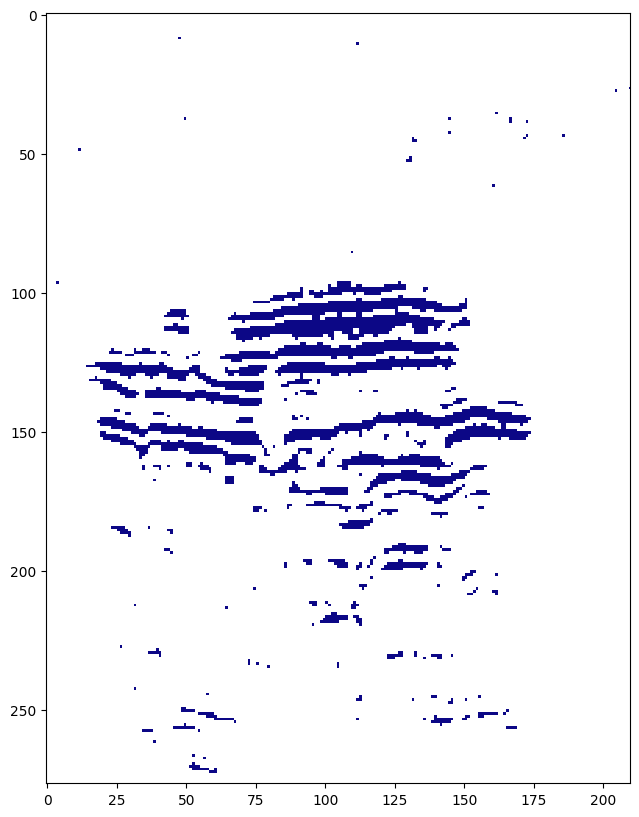

In [113]:
co2 = sliceSeismic_water.loc[sliceSeismic_water["labels"] == 0]
co29406 = (len(co2))
data = co2.pivot(columns = "x", index = "z", values = "labels")
fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(data, cmap = "plasma")

C:\Users\punch\AppData\Local\Temp\ipykernel_9312\1476057375.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sliceSeismic["labels"] = kmeans.labels_


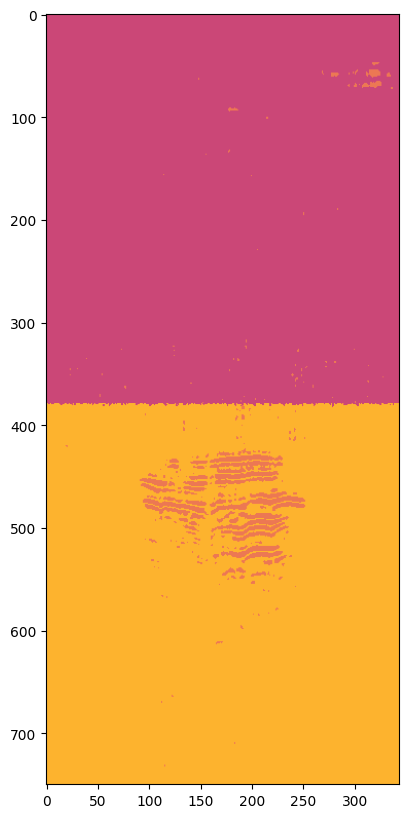

In [114]:
seismic["diff0106"] = abs(seismic["01"] - seismic["06"])
sliceSeismic = seismic.loc[seismic["y"] ==  1840]
scaler = StandardScaler()
scaled_seismic = scaler.fit_transform(sliceSeismic)
no_x = sliceSeismic.filter(["z", "diff0106"], axis=1)
no_x = scaler.fit_transform(no_x)
kmeans = KMeans(
init="random",
n_clusters=3,
n_init=10,
max_iter=500
)

kmeans.fit(no_x)
sliceSeismic["labels"] = kmeans.labels_
data = sliceSeismic.pivot(columns = "x", index = "z", values = "labels")
fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(data, cmap = "plasma", vmin = -3, vmax = 3)
plt.show(fig)


C:\Users\punch\AppData\Local\Temp\ipykernel_9312\3095556215.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sliceSeismic_water["labels"] = kmeans.labels_


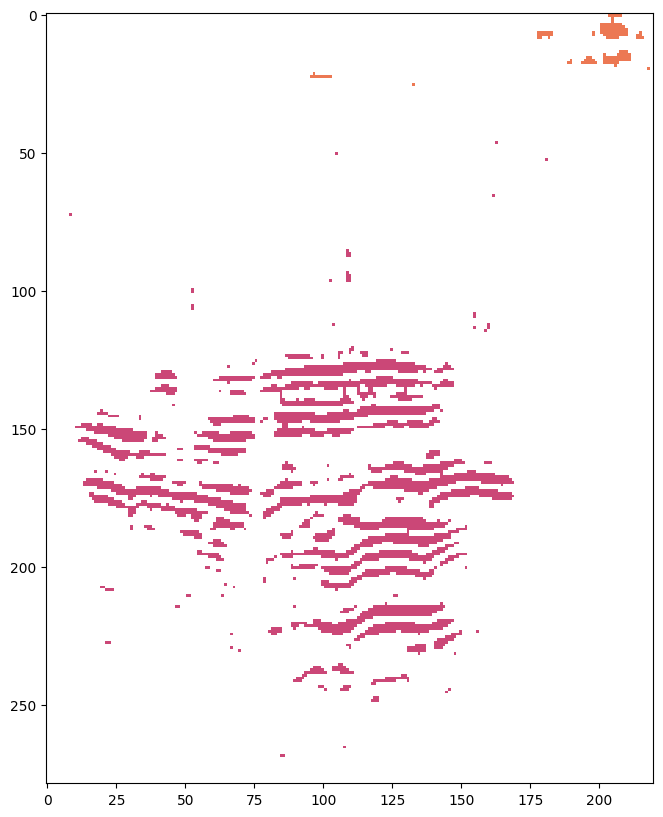

In [115]:
labels_sizes=sliceSeismic.groupby(["labels"]).size()
#print(labels_sizes)
#print(type(labels_sizes))
label_of_carbon_dioxide=labels_sizes.argmin()
#print("krowa")
#print(label_of_carbon_dioxide)
#print(type(label_of_carbon_dioxide))
#print(label_of_carbon_dioxide.shape)
#print(len(label_of_carbon_dioxide))
sliceSeismic_water = sliceSeismic[sliceSeismic["labels"]==label_of_carbon_dioxide]
scaler = StandardScaler()
scaled_seismic_water = scaler.fit_transform(sliceSeismic_water)
no_x = sliceSeismic_water.filter(["z", "x"], axis=1)
no_x = scaler.fit_transform(no_x)
kmeans = KMeans(
init="random",
n_clusters=2,
n_init=10,
max_iter=500
)

kmeans.fit(no_x)
sliceSeismic_water["labels"] = kmeans.labels_
data = sliceSeismic_water.pivot(columns = "x", index = "z", values = "labels")
fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(data, cmap = "plasma", vmin = -3, vmax = 3)

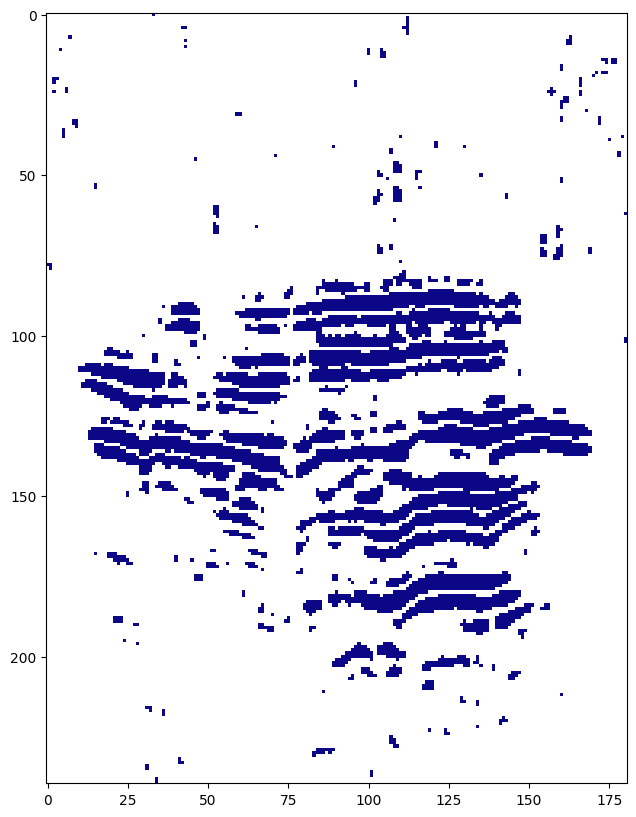

In [116]:
co2 = sliceSeismic_water.loc[sliceSeismic_water["labels"] == 0]
co20106 = (len(co2))
data = co2.pivot(columns = "x", index = "z", values = "labels")
fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(data, cmap = "plasma")

C:\Users\punch\AppData\Local\Temp\ipykernel_9312\173541457.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sliceSeismic["labels"] = kmeans.labels_


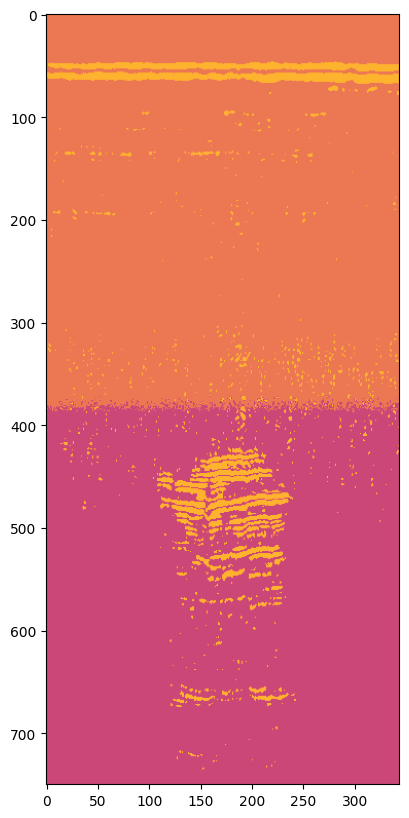

In [117]:
seismic["diff9401"] = abs(seismic["94"] - seismic["01"])
sliceSeismic = seismic.loc[seismic["y"] ==  1840]
scaler = StandardScaler()
scaled_seismic = scaler.fit_transform(sliceSeismic)
no_x = sliceSeismic.filter(["z", "diff9401"], axis=1)
no_x = scaler.fit_transform(no_x)
kmeans = KMeans(
init="random",
n_clusters=3,
n_init=10,
max_iter=500
)

kmeans.fit(no_x)
sliceSeismic["labels"] = kmeans.labels_
data = sliceSeismic.pivot(columns = "x", index = "z", values = "labels")
fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(data, cmap = "plasma", vmin = -3, vmax = 3)
plt.show(fig)


C:\Users\punch\AppData\Local\Temp\ipykernel_9312\3095556215.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sliceSeismic_water["labels"] = kmeans.labels_


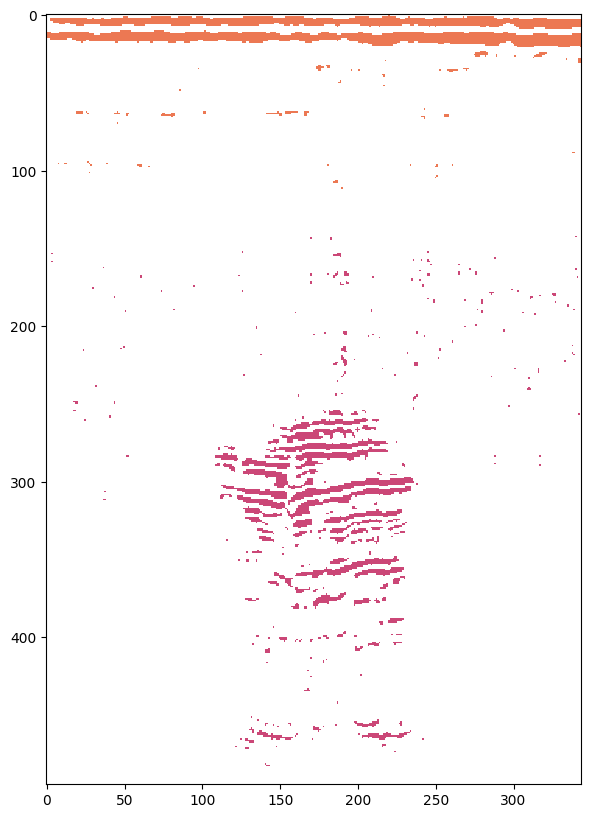

In [118]:
labels_sizes=sliceSeismic.groupby(["labels"]).size()
#print(labels_sizes)
#print(type(labels_sizes))
label_of_carbon_dioxide=labels_sizes.argmin()
#print("krowa")
#print(label_of_carbon_dioxide)
#print(type(label_of_carbon_dioxide))
#print(label_of_carbon_dioxide.shape)
#print(len(label_of_carbon_dioxide))
sliceSeismic_water = sliceSeismic[sliceSeismic["labels"]==label_of_carbon_dioxide]
scaler = StandardScaler()
scaled_seismic_water = scaler.fit_transform(sliceSeismic_water)
no_x = sliceSeismic_water.filter(["z", "x"], axis=1)
no_x = scaler.fit_transform(no_x)
kmeans = KMeans(
init="random",
n_clusters=2,
n_init=10,
max_iter=500
)

kmeans.fit(no_x)
sliceSeismic_water["labels"] = kmeans.labels_
data = sliceSeismic_water.pivot(columns = "x", index = "z", values = "labels")
fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(data, cmap = "plasma", vmin = -3, vmax = 3)

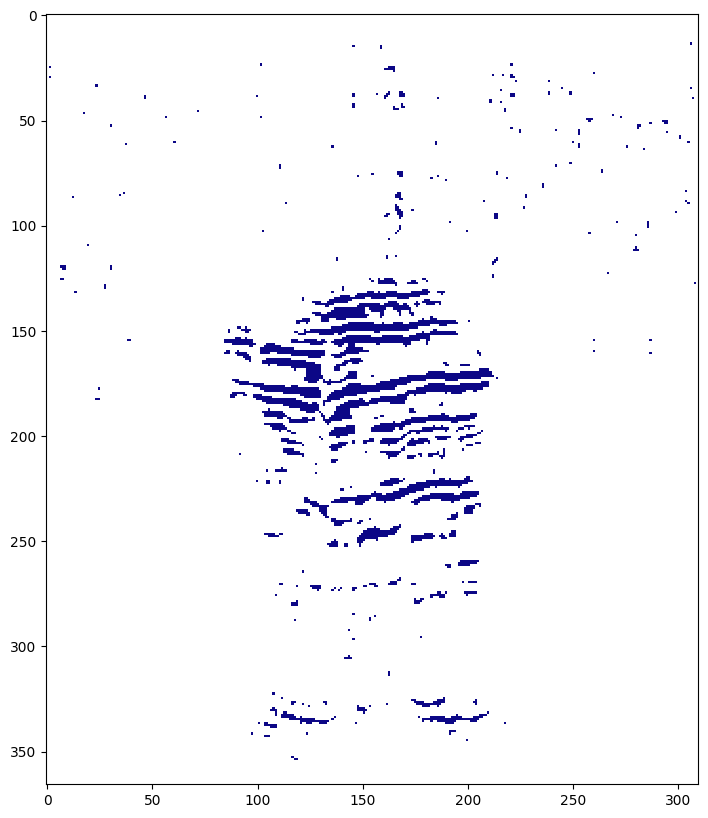

In [119]:
co2 = sliceSeismic_water.loc[sliceSeismic_water["labels"] == 0]
co29401 = (len(co2))
data = co2.pivot(columns = "x", index = "z", values = "labels")
fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(data, cmap = "plasma")

In [120]:
print(co29406)
print(co29401)
print(co20106)

6470
8259
5917
